# Playing with PyTorch

<b>_A lot_</b> easier than Tensorflow but still not as slick as numpy I or whatever I'm imagining in my head. I guess I just dislike having to constantly dealing with typing.

In [1]:
import numpy as np
import scipy.stats as stats
import sklearn.linear_model as lms
import matplotlib.pyplot as graph
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as fx
from torch.autograd import Variable, grad

import pyro.distributions as pyrodist

from rosey.helpers import vec_to_array
 
graph.style.use('fivethirtyeight')

/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


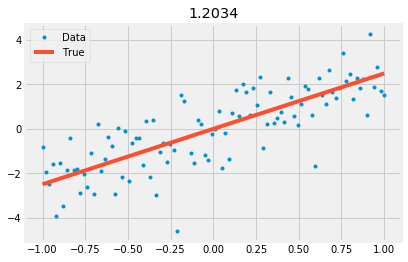

In [2]:
true_m = 2.5
x = np.linspace(-1.0, 1.0, 100)
y = true_m * x + stats.norm.rvs(size=x.shape)

x, y = vec_to_array(x), vec_to_array(y)

graph.title(mean_squared_error(y, true_m * x).round(4))
graph.plot(x, y, '.', label='Data')
graph.plot(x, 2.5*x, label='True')
graph.legend()
graph.show()

In [3]:
def how_close(guess_m, guess_b):
    return abs(guess_m - true_m), abs(guess_b)

# SKLearn

In [4]:
lm = lms.LinearRegression().fit(x, y)
print(lm.coef_, lm.intercept_)
print(how_close(lm.coef_, lm.intercept_))

[[2.37097698]] [-0.02193155]
(array([[0.12902302]]), array([0.02193155]))


# PyTorch (Module Method)

In [5]:
dtype = torch.FloatTensor
y_torch, x_torch = torch.from_numpy(y), torch.from_numpy(x)

y_torch = Variable(y_torch, requires_grad=False).type(dtype)
x_torch = Variable(x_torch, requires_grad=False).type(dtype)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.node = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x_in):
        return self.node(x_in)  

In [6]:
print(((y_torch - (2.5 * x_torch)) ** 2).mean())
print(((y_torch - (2.5 * x_torch)) ** 2).mean().data.numpy())

Variable containing:
 1.2034
[torch.FloatTensor of size 1]

[1.2034185]


In [7]:
model = Model()
loss_func = nn.MSELoss()
learning_rate = 1e-2
tolerance = 1e-9
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
mse_last = 1e6

train_loop = tqdm(range(5000))
for i in train_loop:
    epoch = i + 1
    
    # Reset gradients
    optimiser.zero_grad()
    
    # Predict
    y_hat = model(x_torch)
    
    # Compute fit
    mse_i = loss_func(y_hat, y_torch)
    train_loop.set_description(f'{i} -> {mse_i.data[0]:0.5f}')    
    
    # Early termination condition
    if ((mse_last - mse_i) < tolerance).data.numpy():
        break
    mse_last = mse_i.data[0]
    
    # Compute gradients and update weights
    mse_i.backward()
    
    # NOTE: You can update the weights anyway you want!
    # Example here http://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn 
    # For now I'm just going to use Adam
    optimiser.step()

module_results = [p.data.numpy() for p in model.parameters()]
print(module_results)
print(how_close(*module_results))

582 -> 1.19730:  11%|█         | 549/5000 [00:01<00:09, 454.27it/s]

[array([[2.3630676]], dtype=float32), array([-0.02193153], dtype=float32)]
(array([[0.13693237]], dtype=float32), array([0.02193153], dtype=float32))


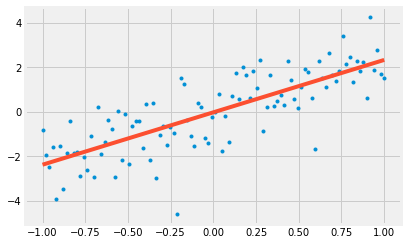

In [8]:
graph.plot(x_torch.data.numpy(), y_torch.data.numpy(), '.')
graph.plot(x_torch.data.numpy(), model(x_torch).data.numpy())
graph.show()

# PyTorch (Arbitrary Method)

with functions

In [9]:
def linear_model(x_in, m_in, b_in):
    return (x_in * m_in) + b_in

def mse_loss(true, pred):
    return ((pred - true) ** 2).mean()


# Model Variables
m = Variable(torch.randn(1), requires_grad=True)
b = Variable(torch.randn(1), requires_grad=True)


# Training logic
learning_rate = 1e-2
loss_last = 1e6
tolerance = 1e-9
optimiser = torch.optim.Adam([m, b], lr=learning_rate)  # Optimise the list given
train_loop = tqdm(range(5000))
for i in train_loop:
    epoch = i + 1
    
    # Reset gradients
    optimiser.zero_grad()
    
    # Predict
    y_pred = linear_model(x_torch, m, b)
    loss_i = mse_loss(y_torch, y_pred)
    train_loop.set_description(f'{epoch} -> {loss_i.data[0]:0.5f} | y = {m.data[0]:0.3f} x + {b.data[0]:0.3f}')
    
    # Check for early termination
    if ((loss_last - loss_i) < tolerance).data.numpy():
        break
    loss_last = loss_i
    
    # Compute gradients and update weights
    loss_i.backward()
    optimiser.step()
    
print(how_close(m.data[0], b.data[0]))


  0%|          | 0/5000 [00:00<?, ?it/s]
605 -> 1.19728 | y = 2.368 x + -0.022:  12%|█▏        | 589/5000 [00:01<00:09, 461.93it/s]

(0.13227558135986328, 0.022059213370084763)


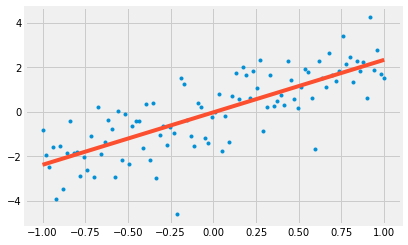

In [10]:
graph.plot(x_torch.data.numpy(), y_torch.data.numpy(), '.')
graph.plot(x_torch.data.numpy(), linear_model(x_torch, m, b).data.numpy())
graph.show()

# MLE in PyTorch 

Since the loss can literally be anything you can right

In [11]:
def mle_loss(true, pred, sd_hat):
    residuals = pred - true
    loglikelihood = torch.from_numpy(
        stats.norm(0, sd_hat.data.numpy()).logpdf(residuals.data.numpy())
    )
    return -loglikelihood.sum()


# Model Variables
m = Variable(torch.randn(1), requires_grad=True)
b = Variable(torch.randn(1), requires_grad=True)  # randn -> N(0, 1)
sd = Variable(torch.rand(1), requires_grad=True)  # rand -> Unif(0, 1)


# Training logic
learning_rate = 1e-2
loss_last = 1e6
optimiser = torch.optim.Adam([m, b, sd], lr=learning_rate)  # Optimise the list given
train_loop = tqdm(range(2500))
for i in train_loop:
    epoch = i + 1
    
    # Reset gradients
    optimiser.zero_grad()
    
    # Predict
    y_pred = linear_model(x_torch, m, b)
    loss_i = mle_loss(y_torch, y_pred, sd)
    train_loop.set_description(
        f'{epoch} -> {loss_i.data[0]:0.5f} | y = {m.data[0]:0.3f} x + {b.data[0]:0.3f}, eps = {sd.data[0]:0.3f}'
    )
    
    # Check for early termination
    if ((loss_last - loss_i) < tolerance).data.numpy():
        break
    loss_last = loss_i
    
    # Compute gradients and update weights
    loss_i.backward()
    optimiser.step()
    
print(how_close(m.data[0], b.data[0]))


  0%|          | 0/2500 [00:00<?, ?it/s]


AttributeError: 'float' object has no attribute 'data'